<h1>Goal: build a model that can predict house prices</h1>

- the price of the house can very by many different dimensions
- it is so difficult that you usually have to get an inspector to give a rating
- this model should make it easier for our customer to get a reference price

<b>Initial hypothesis:</b>
- that basic house descriptors can be used to measure the price of a home

## Imports

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import wrangle
import prepare
import acquire
import env
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from scipy import stats
from sklearn.preprocessing import MinMaxScaler

## Acquire

- data from https://www.kaggle.com/datasets/kaggle/kaggle-survey-2017
- initially contained 52442 rows and and 17 columns before cleaning
- each row represents a house listing on Zillow
- each column represents a feature of the property

From the scope of what is wanted I have adjusted my SQL query to recieve 52442 rows. So now that we have the information then what? Now we dropp what we do not need. Since there are many differing features to choose from it would be easier to finds what has the most impact. I am going to choose:
- bedroomcnt
- bathroomcnt
- calculatedfinishedsquarefeet
- taxvaluedollarcnt
- yearbuilt
- fips

In [2]:
df=acquire.zillow_data()
df.head(3)

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,yearbuilt,taxvaluedollarcnt
0,3.5,4.0,3100.0,6059.0,1998.0,1023282.0
1,1.0,2.0,1465.0,6111.0,1967.0,464000.0
2,2.0,3.0,1243.0,6059.0,1962.0,564778.0


# Prepare

Now taking in the data we transform it into a train test split to feed into my machine learning models

> I have dropped the null values I have found and have decided to keep the project scope wide. In that I am keeping the outliers.


In [3]:
df = prepare.wrangled_zillow(df)
df.head(3)

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,yearbuilt,taxvaluedollarcnt
0,3.5,4.0,3100.0,6059.0,1998.0,1023282.0
1,1.0,2.0,1465.0,6111.0,1967.0,464000.0
2,2.0,3.0,1243.0,6059.0,1962.0,564778.0


# Train, Test, Validate

From here we can scale, which will be needed in this format to model

In [4]:
train, validate, test = prepare.traintestsplit(df)

I have gone with keeping 80% of the information  so  that my model has the most to train on

## Explore

## best graphs

In [5]:
#we have this here to compare to the p-values given
α = 0.05

<p><b>Null_Hypothesis: </b>
That the number of bedrooms has no relationship to the house price</p>
<b>Alternative hypothesis: </b>
That the number of bedrooms has a relationship to the house price

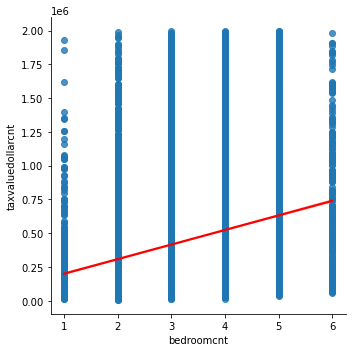

In [6]:
sns.lmplot(x="bedroomcnt", y="taxvaluedollarcnt", data=train, line_kws={'color': 'red'})
plt.show()

Roughly a small linear relationship between bedroom count and "price"

In [7]:
corr, p = stats.pearsonr(train.bedroomcnt, train.taxvaluedollarcnt)
corr, p

(0.26998459281241166, 0.0)

In [8]:
if α > p:
    print("We reject the null hypothesis")

We reject the null hypothesis


What the statistical test tells us here is that there is in fact a relationship between the amount of bedrooms and the price of the house. It also tells us that while being meaningful there maybe stronger drivers to measure against

<hr>

<p><b>Null_Hypothesis: </b>
That the number of bathrooms has no relationship to the house price</p>
<b>Alternative hypothesis: </b>
That the number of bathrooms has a relationship to the house price

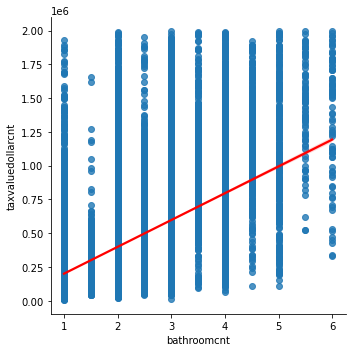

In [9]:
sns.lmplot(x="bathroomcnt", y="taxvaluedollarcnt", data=train, line_kws={'color': 'red'})
plt.show()
#steeper slope here can imply higher causality towards "price"

In [10]:
corr, p = stats.pearsonr(train.bathroomcnt, train.taxvaluedollarcnt)
corr, p

(0.5005506051404705, 0.0)

In [11]:
if α > p:
    print("We reject the null hypothesis")

We reject the null hypothesis


What the statistical data above shows us is that there is a positive relationship between number of bathrooms and price. More over that the significance is quite high

<hr>

<p><b>Null_Hypothesis: </b>
That the amount of square feet has no relationship to the house price</p>
<b>Alternative hypothesis: </b>
That the amount of square feet has a relationship to the house price

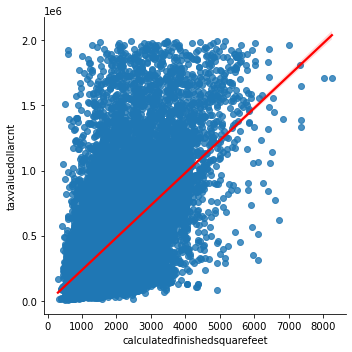

In [12]:
sns.lmplot(x="calculatedfinishedsquarefeet", y="taxvaluedollarcnt", data=train, line_kws={'color': 'red'})
plt.show()
#most 45 degree ish line so far
#tell about relationship as well as hypotheses and stats test with correlation test

In [13]:
corr, p = stats.pearsonr(train.calculatedfinishedsquarefeet, train.taxvaluedollarcnt)
corr, p

(0.5721633427826447, 0.0)

In [14]:
if α > p:
    print("We reject the null hypothesis")

We reject the null hypothesis


What the statistical data above shows us is that there is a positive relationship between how much square feet there are and price. More over that the significance is quite high

<hr>

<p><b>Null_Hypothesis: </b>
That the area has no relationship to the house price</p>
<b>Alternative hypothesis: </b>
That the area has a relationship to the house price

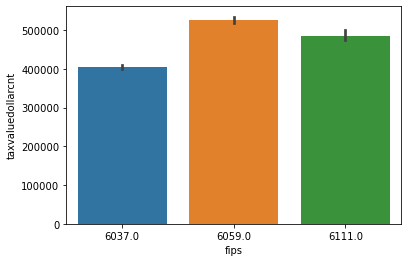

In [15]:
#For this one we have swapped from lmplot to a bar plot because it yeilds cleaner answers
sns.barplot(x="fips", y="taxvaluedollarcnt", data=train)
plt.show()
#we explore off of train
#really hammer home

In [16]:
t, p = stats.ttest_ind(train[train['fips'] == 6059.0].taxvaluedollarcnt,
                       train[train['fips']== 6111.0].taxvaluedollarcnt, 
                       equal_var=False)
t, p / 2
#correlation here are two series
#running two t tests here
#compare series to series

(5.328882585666712, 5.171424318304606e-08)

In [17]:
t, p = stats.ttest_ind(train[train['fips'] == 6111.0].taxvaluedollarcnt,
                       train[train['fips'] == 6037.0].taxvaluedollarcnt, 
                       equal_var=False)
t, p / 2

(11.844959063238885, 5.05423419246211e-32)

In [18]:
if α > p:
    print("We reject the null hypothesis")

We reject the null hypothesis


<b>What the above statistical test tells us is that there are differences in prices of houses between counties.
    
Between Orange County (6059) Los Angelos (6111) there is some difference
    
But between Los Angelos (6111) and Ventura County (6059) there is an even greater difference </b>

The relationship present here implies that the county of 6059 has a higher on average cost

<hr>

<p><b>Null_Hypothesis: </b>
That the year it was built has no relationship to the house price</p>
<b>Alternative hypothesis: </b>
That the year it was built has a relationship to the house price

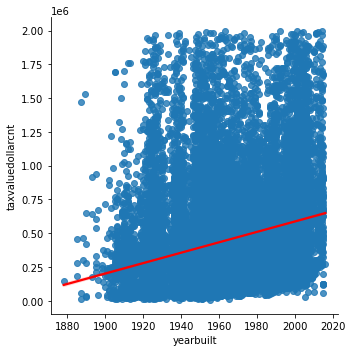

In [19]:
sns.lmplot(x="yearbuilt", y="taxvaluedollarcnt", data=train, line_kws={'color': 'red'})
plt.show()
#this takeaway shows us that year  may not be the most poperful prediction
#the realtionship between 

Takeaways:
- calculated square feet is so far the lead in realtionship to "price

In [20]:
corr, p = stats.pearsonr(train.yearbuilt, train.taxvaluedollarcnt)
corr, p

(0.2479012725902783, 0.0)

In [21]:
if α > p:
    print("We reject the null hypothesis")

We reject the null hypothesis


What the statistical data above shows us is that there is a positive relationship between the year it was built and price. More over that the significance is not so strong

<hr>

## Working with scaled data

> I need a baseline RMSE to compare my accuracy:
> - take the median or mean value
> - use the with more accuracy
> - and compare the RMSE

# Modeling

This may take some time, maybe more time then I know of.

My confidence is not the highest coming into this but I will surely build out some models

In [34]:
x_train_scaled = scaler.transform(train)
x_validate_scaled = scaler.transform(validate)
x_test_scaled = scaler.transform(test)

NameError: name 'scaler' is not defined

In [28]:
x_train_and_validate, x_test = train_test_split(train)
x_train, x_validate = train_test_split(x_train_and_validate)

In [24]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(train.taxvaluedollarcnt)
y_validate = pd.DataFrame(validate.taxvaluedollarcnt)

# 1. Predict price_pred_mean
price_pred_mean = y_train['taxvaluedollarcnt'].mean()
y_train['price_pred_mean'] = price_pred_mean
y_validate['price_pred_mean'] = price_pred_mean

# 2. compute price_pred_median
price_pred_median = y_train['taxvaluedollarcnt'].median()
y_train['price_pred_median'] = price_pred_median
y_validate['price_pred_median'] = price_pred_median

# 3. RMSE of price_pred_mean
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.price_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.price_pred_mean)**(1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

# 4. RMSE of G3_pred_median
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.price_pred_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.price_pred_median)**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  355302.21 
Validate/Out-of-Sample:  351801.88
RMSE using Median
Train/In-Sample:  364345.33 
Validate/Out-of-Sample:  361109.96


In [42]:
#what am I doing here?
# I am testing out how to work with scaled data
X_train = train[['calculatedfinishedsquarefeet']]
y_train = train['taxvaluedollarcnt']

X_validate = validate[['calculatedfinishedsquarefeet']]
y_validate = validate['taxvaluedollarcnt']

X_test = test[['calculatedfinishedsquarefeet']]
y_test = test['taxvaluedollarcnt']

In [44]:
# x_train.shape,
y_train = pd.DataFrame(y_train)
y_train=

In [39]:
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(x_train, y_train.taxvaluedollarcnt)

# predict train
y_train['price_pred_lm'] = lm.predict(x_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.price_pred_lm)**(1/2)

# predict validate
y_validate['price_pred_lm'] = lm.predict(x_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.price_pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

AttributeError: 'Series' object has no attribute 'taxvaluedollarcnt'

In [ ]:
scaler, train_scaled, validate_scaled, test_scaled = prepare.splitmoreways(train, validate, test, return_scaler=True)

In [ ]:
train_scaled

So now I have all of my features scaled apart from year and taxvaluedollar.

Now with all of my features scaled to a MinMaxScaler I can now run models on it.

I am going to want to split my features from target variable

In [ ]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(train.taxvaluedollarcnt)
y_validate = pd.DataFrame(validate.taxvaluedollarcnt)

# 1. Predict price_pred_mean
price_pred_mean = y_train['taxvaluedollarcnt'].mean()
y_train['price_pred_mean'] = price_pred_mean
y_validate['price_pred_mean'] = price_pred_mean

# 2. compute price_pred_median
price_pred_median = y_train['taxvaluedollarcnt'].median()
y_train['price_pred_median'] = price_pred_median
y_validate['price_pred_median'] = price_pred_median

# 3. RMSE of price_pred_mean
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.price_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.price_pred_mean)**(1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

# 4. RMSE of price_pred_median
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.price_pred_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.price_pred_median)**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2),
     "\nOrigincal baseline:", round(baseline, 2))

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
#predicting y from trained data
#predict rules
model = LinearRegression().fit(train_scaled, train.taxvaluedollarcnt)
predictions = model.predict(train_scaled)

In [27]:
#THIS ONE HERE IT IS THE KEY

# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(x_train, y_train.taxvaluedollarcnt)

# predict train
y_train['G3_pred_lm'] = lm.predict(x_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.G3_pred_lm)**(1/2)

# predict validate
y_validate['G3_pred_lm'] = lm.predict(x_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.G3_pred_lm)**(1/2)

# predict test
y_test['G3_pred_lm'] = lm.predict(x_test)

rmse_test = mean_squared_error(y_test.taxvaluedollarcnt, y_test.G3_pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate,
     "\nRoomatoid arthritis:", rmse_test)


ValueError: Found input variables with inconsistent numbers of samples: [15977, 28405]

In [ ]:
#need error reading such as RMSE

From here it would be best practice

Pick best model, run all models then choose 1 from there, the chosen one gets the test data set

# Evaluate

Of the three machine learning models we have used Linear Regression and Lasso Lars are about the same

I would suggest we use the linear regression model to guide the project forward

### now can run it against the test data set to determine final accuracy